# HW_06 : Нейросети в обработке текста. 
> Рекуррентные нейронные сети. LSTM. GRU.

Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)


In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

DATA_PATH = '../data/отзывы за лето.xls'

<b>Настройка GPU</b>

In [59]:
import tensorflow as tf
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [60]:
# глобальные переменнные для предобработки
max_words = 2000
max_len = 40

In [61]:
df = pd.read_excel(DATA_PATH, parse_dates=[2])
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


### Бинарная классификация

In [62]:
df_bin = df[df['Rating']!=3]

In [63]:
df_bin['Target'] = (df['Rating']>3).astype('uint8')

In [64]:
# распределение не очень, но рабочее
df_bin.Target.value_counts(normalize=True)

1    0.846871
0    0.153129
Name: Target, dtype: float64

#### Препроцессинг

In [65]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [66]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_bin['Content'] = df_bin['Content'].apply(preprocess_text)

In [67]:
# разобьем датасет на трайн-валид-тест 70-15-15
train, test = train_test_split(df_bin, test_size=0.7, shuffle=True, stratify = df_bin['Target'], random_state=42)
valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=42)

In [68]:
train_corpus = " ".join(train["Content"])
train_corpus = train_corpus.lower()

In [69]:
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens if word.isalnum()]

In [70]:
# наиболее часто встречающиеся токены
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [71]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [72]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [73]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in test["Content"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in valid["Content"]], dtype=np.int32)

In [74]:
y_train = train["Target"]
y_test = test["Target"]
y_valid = valid["Target"]

In [75]:
x_train[5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 648,  19, 122, 190, 959, 959,
       959], dtype=int32)

### Модели

In [76]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN , LSTM, GRU, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping 

In [77]:
epochs = 50
batch_size = 512

In [78]:
rnn_type = ['R', 'L', 'G']

In [79]:
def plot_metrics(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [80]:
def make_rnn_layer(param):
    if param == 'R':
        layer = SimpleRNN(64)
        print('\n=== SimpleRNN ===\n')
    elif param == 'L':
        layer = LSTM(64, recurrent_dropout=0.4)
        print('\n=== LSTM ===\n')
    elif param == 'G':
        layer = GRU(64, recurrent_dropout=0.4)
        print('\n=== GRU ===\n')    
    else:
        raise Exception('make_layer(param) -> param have to be in("R", "L", "G")')
    return layer 

In [81]:
def make_model(param : str) -> object:
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=max_len, input_length=max_len, trainable=True, mask_zero=True))
    model.add(Masking(mask_value=0.0))
    model.add(make_rnn_layer(param))
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [82]:
def fit_model(model):
    if not model:
        return
    model.summary()
    
    tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)  

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2,
                        callbacks=[tensorboard, early_stopping])
    return history
    

In [83]:
def test_model(model):
    
    score = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=1)
    print('\n')
    print('Validation score:', score[0])
    print('Validation accuracy:', score[1])
    
    results = model.predict(x_test, batch_size=batch_size, verbose=1)
    print(f'Test score: {round(roc_auc_score(y_test, results),3)}')
    print('\n'*3)
    print('=='*30)


=== SimpleRNN ===

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 40)            80000     
_________________________________________________________________
masking_6 (Masking)          (None, 40, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                6720      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_12 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None

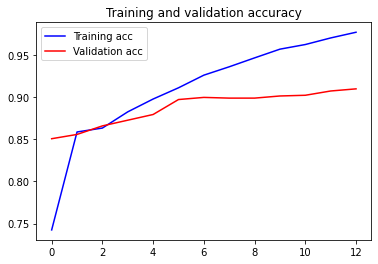

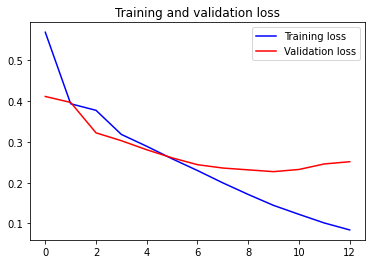

14/14 [==============================] - 0s 4ms/step - loss: 0.2352 - accuracy: 0.9023


Validation score: 0.2351703941822052
Validation accuracy: 0.90234375
14/14 [==============================] - 0s 3ms/step
Test score: 0.939





=== LSTM ===

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 40)            80000     
_________________________________________________________________
masking_7 (Masking)          (None, 40, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                26880     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
____

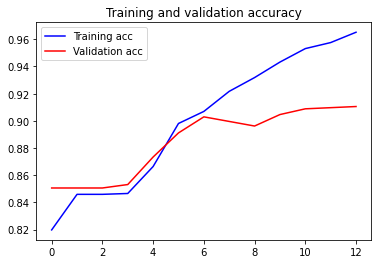

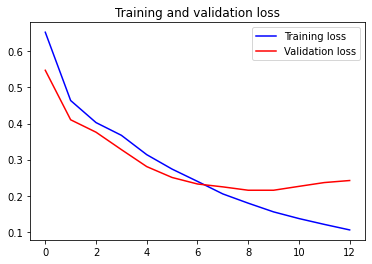

14/14 [==============================] - 0s 10ms/step - loss: 0.2347 - accuracy: 0.8987


Validation score: 0.2347085326910019
Validation accuracy: 0.8987268805503845
14/14 [==============================] - 0s 10ms/step
Test score: 0.942





=== GRU ===

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 40)            80000     
_________________________________________________________________
masking_8 (Masking)          (None, 40, 40)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                20352     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_16 (Activation)   (None, 64)                0     

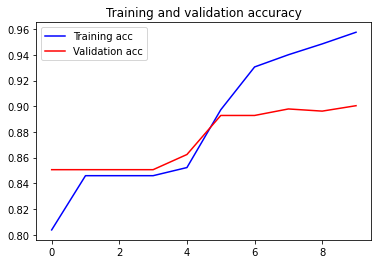

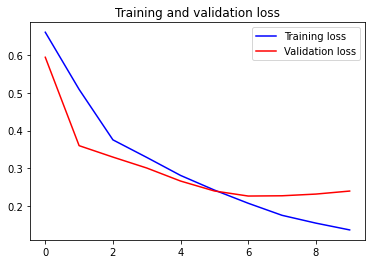

14/14 [==============================] - 0s 8ms/step - loss: 0.2495 - accuracy: 0.8902


Validation score: 0.24945318698883057
Validation accuracy: 0.8901909589767456
14/14 [==============================] - 0s 8ms/step
Test score: 0.925






In [84]:
for param in rnn_type:
    model = make_model(param)
    hist = fit_model(model)
    plot_metrics(hist)
    test_model(model)

### Выводы

Лучший результат показал LSTM, 2 место досталось SimpleRNN и на последнем GRU - при одинаковых параметрах сети. Стоит отметить что даже лучший результат LSTM оказался ниже чем результат CNN сети из прошлой темы.

Видимо для каждой сети нужно подбирать индивидуальные настройки и конфигурацию.